Written by Jair Lemmens
For educational use only

In [1]:
import torch.nn as nn
import torch
from torch.distributions.multivariate_normal import MultivariateNormal

from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

from VAE_modules_20_11 import Decoder
from main_modules import VQVAE ,StackedMLP_norm,Temporal_Analyser

import numpy as np

from IPython.display import clear_output

from scipy.ndimage import gaussian_filter1d
import os

Written by Jair Lemmens
For educational use only

In [2]:
total = []

In [3]:
class SwissData2(Dataset):
    def __init__(self,path,grayscale = False,roll=False):
        self.path = path
        self.filenames = os.listdir(f'{self.path}/graphs/')
        self.grayscale = grayscale
        self.roll = roll
    def __len__(self):
        return(len(self.filenames))
    
    def __getitem__(self, index):
        filename = self.filenames[index]
        if self.grayscale !=True:
            graphs = torch.load(f'{self.path}/graphs/{filename}')
            plans = torch.load(f'{self.path}/plans/{filename}')
        else:
            graphs = torch.zeros(1)
            plans = torch.load(f'{self.path}/plans/{filename}').sum(-3)
        
        if self.roll:
            plans = plans.roll(list(np.random.randint(-10,10,2)),(-1,-2))

        return {'graphs': graphs, 'plans': plans}

In [4]:
vqvae = VQVAE(device='cuda:0',dims=[1,32,16,2],codebook_size=16)
vqvae.load_state_dict(torch.load('./trained_modules/vqvaestrokemodels/backup_19_04/vqvae/VQVAE(dims=[1,32,16,2],codebook_size=16).pt'))
vqvae.eval()

renderer = nn.Sequential(Decoder(depths=[1,1,1,1,1,3],dims=[1,4,4,4,4,3]),nn.Sigmoid()).to('cuda:0')
renderer.load_state_dict(torch.load('./trained_modules/vqvaestrokemodels/backup_19_04/renderer/nn.Sequential(Decoder(depths=[1,1,1,1,1,3],dims=[1,4,4,4,4,3]),nn.Sigmoid()).pt'))
renderer.eval()

entropies = []
means = []
losses = []


In [5]:
def iou(samples,reference):
    with torch.no_grad():
        intersection = (samples*reference).sum([-1,-2,-3])
        union = torch.max(samples,reference).sum([-1,-2,-3])
        score = intersection/(union+1)
        return(score)

def distort_reference(reference,min_distortion=0,max_distortion=1,num_samples=64,model=vqvae):
    _,indices = model.enc(reference)
    new_indices = []
    for environment in indices:
        distortion = torch.rand(1,device=indices.device)*(max_distortion-min_distortion)+min_distortion
        
        new_indices.append(torch.where(torch.rand([num_samples,*environment.shape],device=indices.device)>distortion,environment,torch.randint(size=(num_samples,*environment.shape),high=15,device=indices.device)))
    new_indices = torch.stack(new_indices).flatten(0,-3)
    latents = model.quantizer.get_indices(new_indices)
    variations = model.decoder(latents).sigmoid()>.5
    return(variations,new_indices)


In [6]:
num_eps = 10000
num_samples = 64
num_environments = 256
swissdata_loader = DataLoader(SwissData2('./data/swiss/',grayscale=True, roll=True),num_environments,shuffle=True)
ppo_clip_val = .15
cov_mat = torch.diag(torch.ones(4,device='cuda')).unsqueeze(0)*.15
total = []
transformer_dims = [16,32,64]

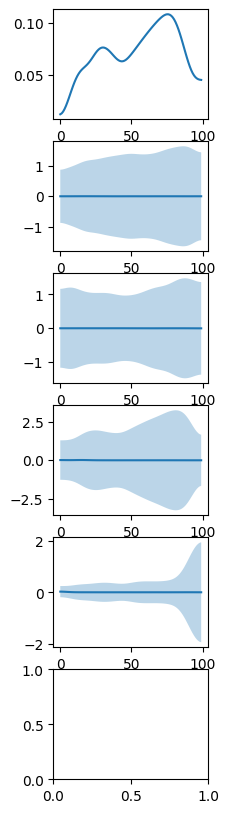

100%|██████████| 5000/5000 [11:09<00:00,  7.46it/s, avg_improv=tensor(0.0527), loss=-0.0523, ppo_iters=4]


In [10]:
for _ in range(5):
    temporal_analyser = Temporal_Analyser(32,16,4).to('cuda')
    actor = StackedMLP_norm(input_size=32,output_size=4,num_layers=1).to('cuda')

    optimiser = torch.optim.Adam(list(temporal_analyser.parameters())+list(actor.parameters()),lr=1e-3,betas=[.95,.95])

    entropies = []
    means = []
    losses = []

    num_steps = 5000
    pbar = tqdm(range(num_steps))

    for step in enumerate(pbar):


        references = next(iter(swissdata_loader))["plans"].to(torch.float).unsqueeze(-3).to('cuda').clamp(0,1)

        batched_samples,batched_idx = distort_reference(references,.1,.4,num_samples)

        B,N,C,W,H = num_environments,num_samples,*batched_samples.shape[-3:]

        batched_idx = batched_idx.reshape(B,N,-1)

        batched_prev_scores = iou(batched_samples.reshape(B,N,C,W,H).permute(1,0,2,3,4),references).permute(1,0)

        norm_batched_prev_scores = batched_prev_scores/torch.sort(batched_prev_scores,dim=-1)[0][:,-1:]
        
        temporal_latents = temporal_analyser(batched_idx,norm_batched_prev_scores.unsqueeze(-1))

        logits = actor(temporal_latents.reshape(B*N,-1))
        dist = MultivariateNormal(logits,scale_tril=cov_mat)
        actions = dist.sample()
        old_logprobs = dist.log_prob(actions)

        alteration = renderer(actions[:,:3].unsqueeze(-1).unsqueeze(-1).sigmoid())

        batched_samples = torch.where(alteration>.5,torch.einsum('i...,i->i...',torch.ones([B*N,C,W,H],device=batched_samples.device),
                                                                    logits[:,-1].sigmoid().round().to(torch.float)),
                                                                    batched_samples.reshape([B*N,C,W,H]))
        
        batched_new_scores = iou(batched_samples.reshape(B,N,C,W,H).permute(1,0,2,3,4),references).permute(1,0)
        
        advantage = nn.functional.leaky_relu((batched_new_scores-batched_prev_scores).detach(),0.2).flatten()
        advantage = torch.clamp(advantage,torch.quantile(advantage,.001),torch.quantile(advantage,.999))

        for ppo_steps in range(5):

            temporal_latents = temporal_analyser(batched_idx,norm_batched_prev_scores.unsqueeze(-1))

            logits = actor(temporal_latents.reshape(B*N,-1))
            dist = MultivariateNormal(logits,scale_tril=cov_mat)
            new_logprob = dist.log_prob(actions)

            policy_ratio = torch.exp(new_logprob - old_logprobs.detach())
            
            clipped_ratio = policy_ratio.clamp(1 - ppo_clip_val, 1 + ppo_clip_val)

            full_loss = policy_ratio*advantage
            clipped_loss = clipped_ratio*advantage

            #loss = -torch.min(full_loss,clipped_loss).mean()- torch.clamp(logits.std(0),0,1.5).mean()*0.0001
            loss = -torch.min(full_loss,clipped_loss).mean()+logits.mean(0).abs().mean()*0.01

            optimiser.zero_grad()
            loss.backward()
            optimiser.step()


        pbar.set_postfix(avg_improv=advantage.mean().cpu(), ppo_iters=ppo_steps, loss = loss.item())

        if (step[0])%50==0:
            
            entropies.append(logits.std(0).detach().cpu())
            means.append(logits.mean(0).detach().cpu())
            losses.append(advantage.mean().cpu())
            clear_output(wait=True)
            fig, axs = plt.subplots(6,1,figsize=[2,10])
            axs[0].plot(gaussian_filter1d(losses, sigma=5))
            temp_entropies = gaussian_filter1d(np.array(entropies), sigma=5,axis =0)
            temp_means = gaussian_filter1d(np.array(means), sigma=5,axis =0)
            upper = temp_means+temp_entropies
            lower = temp_means-temp_entropies
            for i in range(4):
                axs[i+1].fill_between(range(len(upper)),y1=upper[:,i],y2=lower[:,i],alpha=.3)
                axs[i+1].plot(temp_means[:,i])
            plt.show()

    total.append(losses)

0
1
2
3
4


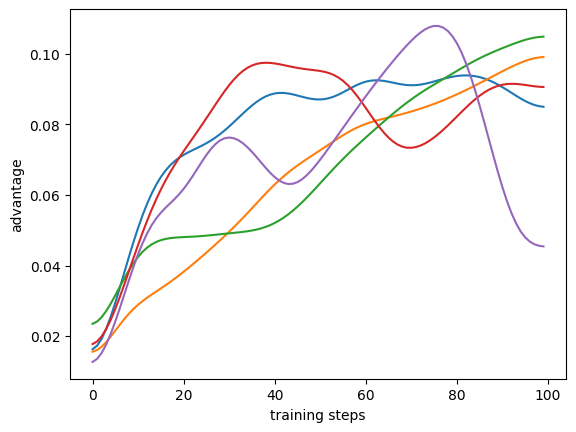

In [11]:
for i,n in enumerate(total):
    n = gaussian_filter1d(n, sigma=5)
    print(i)
    plt.plot(n,label =[16,32,64,64,64][i])
    #plt.legend(title = 'Transformer dims')

plt.ylabel('advantage')
plt.xlabel('training steps')
plt.show()